In [1]:
import pickle

import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from NumpyNN.NN_np import (
    FullyConnectedLayer,
    ReLULayer,
    SigmoidLayer,
    ReLULayer,
    AdamOptimizer,
    CrossEntropyLoss,
    LinearActivation,
    Sequential,
    Optimizer,
    SoftMaxLayer,
    GradientDescentOptimizer,
    CrossEntropyLossWithSoftMax,
    softmax,
    Conv2d,
    Flatten
)

In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
from numpy_resnet import resnet101

In [4]:
def one_hot(y: np.ndarray, n_classes: int):
    encoded = np.zeros((y.size, n_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

In [5]:
def padding(X, pad):
    batch_size, channels, h, w = X.shape
    out = np.zeros((batch_size, channels, h + 2 * pad, w + 2 * pad))
    out[:, :, pad:pad + h, pad:pad + w] = X
    return out

In [6]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

X_train = padding(X_train.reshape(-1, 1, 28, 28), 2).astype(np.float32)
X_test = padding(X_test.reshape(-1, 1, 28, 28), 2).astype(np.float32)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [7]:
y_train.shape, X_train.shape

((60000, 10), (60000, 1, 32, 32))

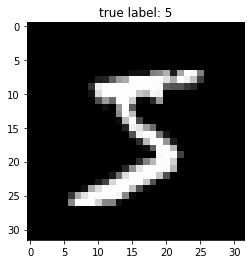

In [8]:
plt.title(f"true label: {np.argmax(y_train[0])}")
plt.imshow(X_train[0].reshape(32, 32))

In [9]:
# The history is calculated for batches in implementation below

def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int):

    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {"batch-"+metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}
    
    for i in range(epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                X, y = X_train, y_train
            elif phase == 'test':
                X, y = X_test, y_test
            
            print(phase)
            epoch_loss = 0
            
            all_true_y = []
            all_pred_y = []
            
            batch_pbar = tqdm(range(0, X.shape[0], batch_size))
            
            for j in batch_pbar:
                # print(f"epoch {i} batch {j}")
                X_b, y_b = X[j:j+batch_size], y[j:j+batch_size]
                y_pred = model.forward(X_b)
                loss_val = loss.forward(y_pred, y_b)

                y_pred_label_b = np.argmax(y_pred, axis=1)
                y_true_label_b = np.argmax(y_b, axis=1)

                history[phase]['batch-accuracy'].append(np.mean(np.array(y_pred_label_b) == np.array(y_true_label_b)))
                history[phase]['batch-loss'].append(loss_val)
                history[phase]['batch-f1_score'].append(f1_score(y_pred_label_b, y_true_label_b, average='macro'))
                
                all_pred_y.extend(y_pred_label_b)
                all_true_y.extend(y_true_label_b)
                epoch_loss += loss_val

                if phase == 'train':
                    loss_gradient = loss.backward()
                    model.backward(loss_gradient)
                    optimizer.step()
                
                progress_string = "batch: "
                for metric_name in metric_names:
                    bmn = 'batch-' + metric_name
                    progress_string+=f"{metric_name}: {history[phase][bmn][-1]:.2f}  "
                batch_pbar.set_description(progress_string)
                
            epoch_accuracy = np.mean(np.array(all_pred_y) == np.array(all_true_y))
            epoch_f_score = f1_score(all_pred_y, all_true_y, average='macro')
            print(f"epoch metrics: loss = {epoch_loss:.2f}, accuracy = {epoch_accuracy:.2f}, f score = {epoch_f_score:.2f}")
            
            
            
            history_name = 'numpy_resnet_history.pickle'

            with open(history_name, 'wb') as f:
                pickle.dump(history, f)

            # with open(history_name, 'rb') as f:
            #     history = pickle.load(f)
            
            for layer in model.trainable_layers:
                layer.input_ = None
            
            model_file_name = 'numpy_resnet_1.pickle'

            with open(model_file_name, 'wb') as f:
                pickle.dump(model, f)
            
            adam_name = './numpy_resnet_adam.pickle'

            with open(history_name, 'wb') as f:
                pickle.dump(optimizer, f)
            
        
    return history

In [9]:
# The history is calculated for the whole epoch in implementation below

def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int):

    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for phase in ['train', 'test']:
            y_pred_labels = []
            y_true_labels = []
            epoch_loss = 0
            if phase == 'train':
                X, y = X_train, y_train
            elif phase == 'test':
                X, y = X_test, y_test
            for j in tqdm(range(0, X.shape[0], batch_size)):
                X_b = X[j:j+batch_size]
                y_b = y[j:j+batch_size]
                y_pred = model.forward(X_b)
                loss_val = loss.forward(y_pred, y_b)

                y_pred_label_b = np.argmax(y_pred, axis=1)
                y_true_label_b = np.argmax(y_b, axis=1)

                epoch_loss += loss_val.item()
                y_pred_labels.extend(y_pred_label_b)
                y_true_labels.extend(y_true_label_b)

                if phase == 'train':
                    loss_gradient = loss.backward()
                    model.backward(loss_gradient)
                    optimizer.step()

            history[phase]['accuracy'].append(np.mean(np.array(y_pred_labels) == np.array(y_true_labels)))
            history[phase]['loss'].append(loss_val)
            history[phase]['f1_score'].append(f1_score(y_pred_labels, y_true_labels, average='macro'))

            
    return history

In [9]:
# Conv2d.backward = Conv2d.backward_as_mat_mul_unified

In [10]:
epochs = 1
batch_size = 1

model = resnet101(10, 1)
# optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 1e-3)
optimizer = AdamOptimizer(model.trainable_layers, learning_rate = 1e-3)
loss = CrossEntropyLossWithSoftMax()

history = train(model, X_train[:5000], y_train[:5000], X_test[:1000], y_test[:1000], optimizer, loss, epochs, batch_size)

  0%|          | 3/5000 [00:31<14:27:16, 10.41s/it]


KeyboardInterrupt: 

In [ ]:
"""
history2 = train(model, X_train, y_train, X_test, y_test, optimizer, loss, 20, batch_size)
for key in history['train']:
    history['train'][key].extend(history2['train'][key])
"""

In [10]:
a = list(set(abs(model.trainable_layers[1].weights_gradient.flatten())))
np.mean(a)

0.0008892841030677987

In [11]:
np.abs(model.trainable_layers[0].weights_gradient.flatten()).mean()

0.04045056523644971

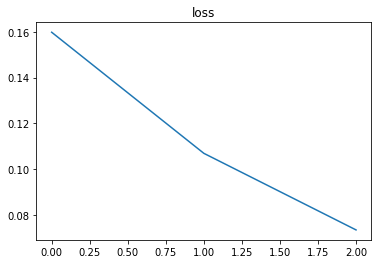

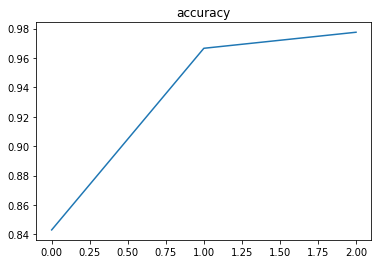

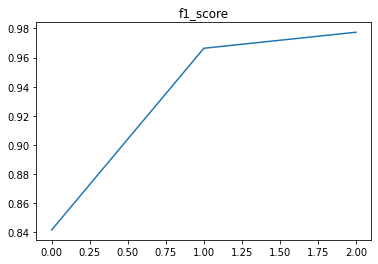

In [12]:
for key, value in history['train'].items():
    if key in ['weights_data', 'mean_trainable_layers']:
        continue
    plt.plot(value)
    plt.title(key)
    plt.show()

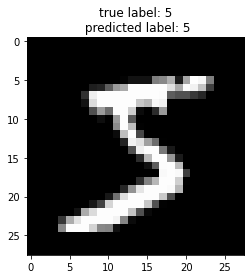

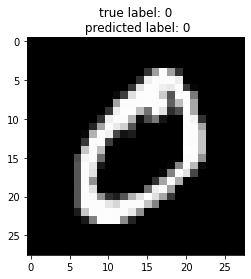

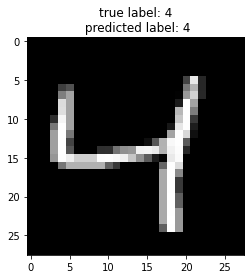

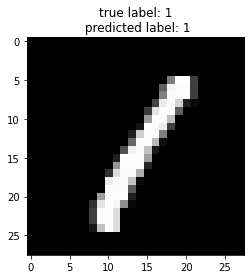

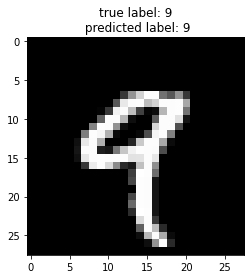

In [13]:
for i in range(5):
    probs_i = softmax(model.forward(X_train[i].reshape(1, 1, 28, 28)))
    plt.title(f"true label: {np.argmax(y_train[i])}\n predicted label: {np.argmax(probs_i)}")
    plt.imshow(X_train[i].reshape(28, 28))
    plt.show()

In [ ]:
"""
def train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):
    for epoch in range(epochs):
        for X_batch, y_batch in get_batches(X, y, batch_size):
            y_pred = model.forward(X_batch)
            loss_gradient = loss.gradient(y_batch, y_pred)
            model.backward(loss_gradient)
            optimizer.step()
        if verbose:
            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")
"""

'\ndef train(model, X: np.ndarray, y: np.ndarray, optimizer: Optimizer, loss, epochs: int, batch_size: int = 32, verbose: bool = True):\n    for epoch in range(epochs):\n        for X_batch, y_batch in get_batches(X, y, batch_size):\n            y_pred = model.forward(X_batch)\n            loss_gradient = loss.gradient(y_batch, y_pred)\n            model.backward(loss_gradient)\n            optimizer.step()\n        if verbose:\n            print(f"Epoch {epoch + 1}/{epochs} loss: {loss(y_batch, y_pred)}")\n'

In [7]:
import torch

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train)

X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test)

def train_torch(model, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor,
          optimizer, loss, epochs: int, batch_size: int):
    
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in tqdm(range(0, X_train.shape[0], batch_size)):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model(X_b_train)
            loss_val = loss(y_pred, y_b_train)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            y_pred_label = np.argmax(y_pred.detach().numpy(), axis=1)
            y_true_label = np.argmax(y_b_train.detach().numpy(), axis=1)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label).item())
            history['train']['loss'].append(loss_val.item())
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro').item())
            
    return history

In [9]:
np.argmax([[1, 2, 3], [4, 5, 6]], axis = 0)

array([1, 1, 1], dtype=int64)

In [10]:
X_train_torch.dtype

torch.float32

In [12]:
in_channels = 1
out_channels = 32
kernel_size = 3
stride = 1
padding = 1
bias = True

height = X_train[0].shape[1]
width = X_train[0].shape[2]

batch_size = 1024
epochs = 3

model_torch = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
    torch.nn.ReLU(),
    torch.nn.Flatten(), 
    torch.nn.Linear(height * width * out_channels, 10),
)

weights_data_torch = []

optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=1e-3)

loss_torch = torch.nn.CrossEntropyLoss()

history_torch = train_torch(model_torch, X_train_torch, y_train_torch, X_test_torch, y_test_torch, optimizer_torch, loss_torch, epochs, batch_size)

100%|██████████| 59/59 [00:39<00:00,  1.49it/s]


In [ ]:
# list(model_torch.parameters())

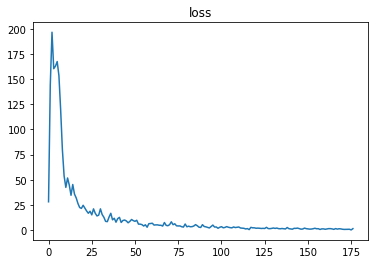

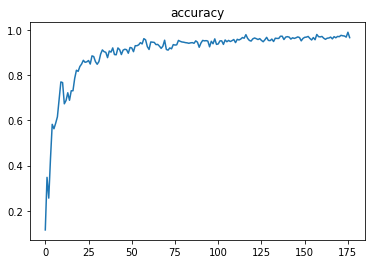

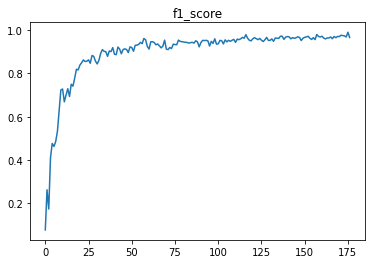

In [51]:
for key, value in history_torch['train'].items():
    plt.plot(value)
    plt.title(key)
    plt.show()